Saved lithology Excel table for BH_1: C:\Users\HOME\Desktop\ML Saline\Borehole\BH_1_lithology_table.xlsx
Saved lithology Excel table for BH_2: C:\Users\HOME\Desktop\ML Saline\Borehole\BH_2_lithology_table.xlsx


C:\Users\HOME\AppData\Local\Temp\ipykernel_8172\2496144398.py:112: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arr = s.fillna(method="pad").fillna(method="bfill").values


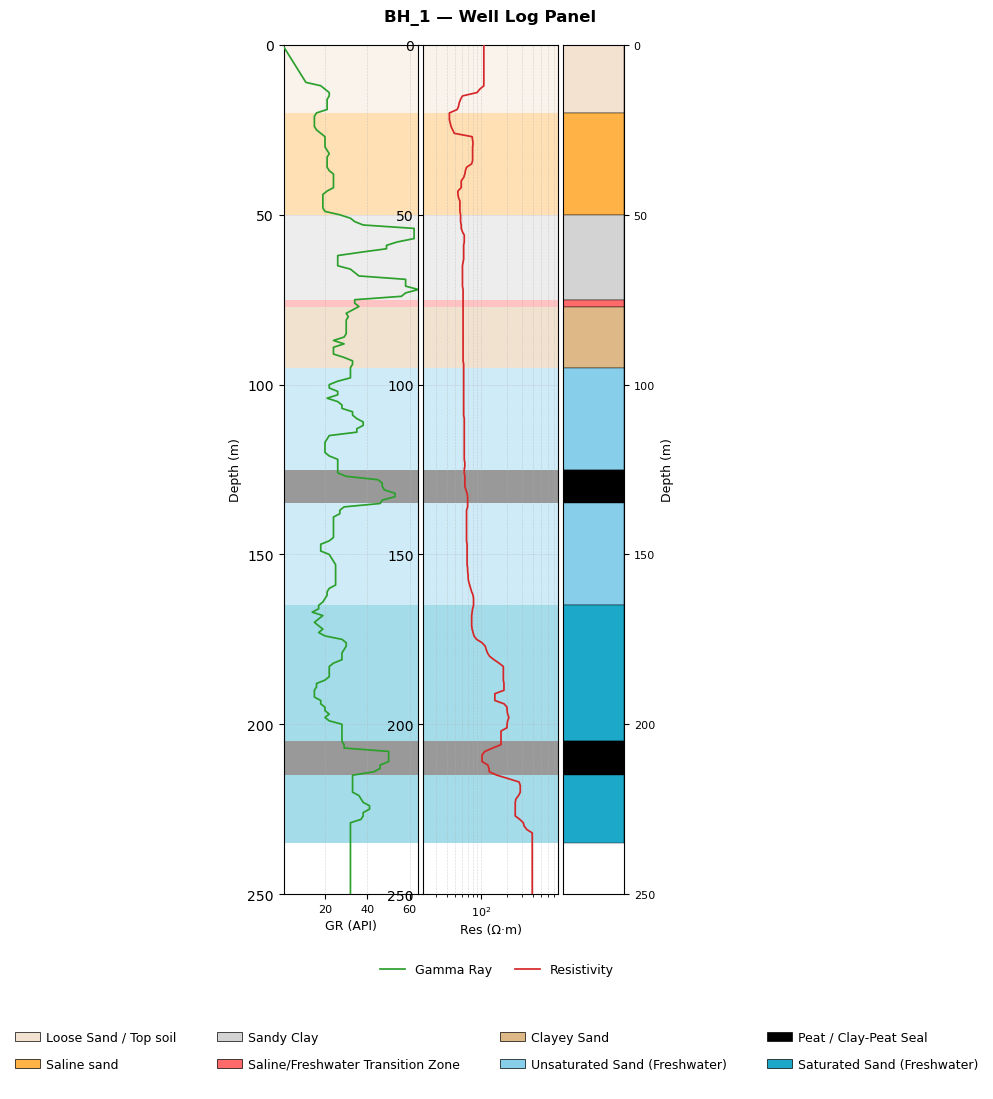

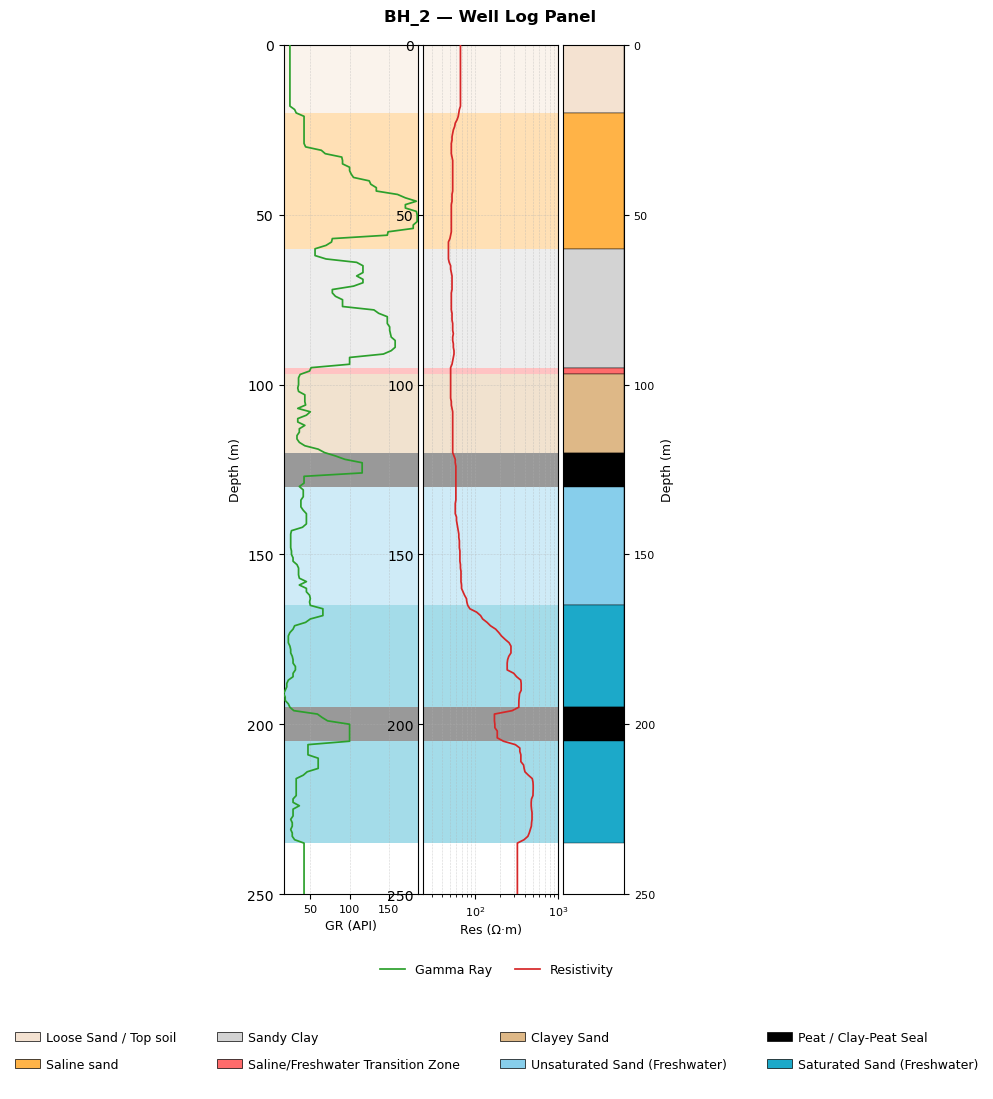

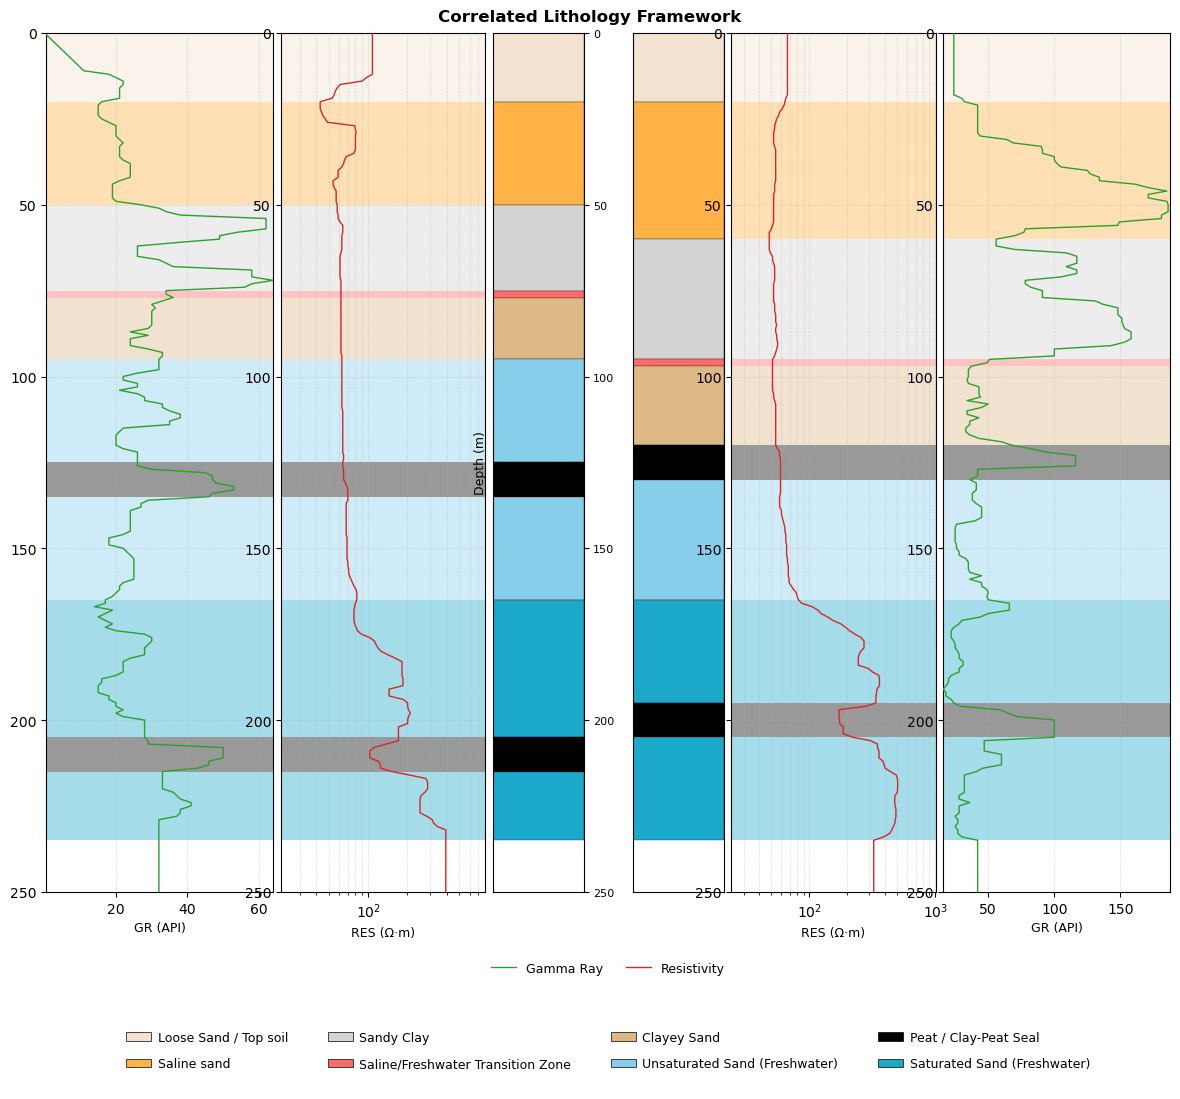

In [8]:
"""
Well-log panels + correlation with faded lithology overlays on GR & RES tracks.
Also saves lithology interval tables to Excel with lithology colors.
"""

import os
import math
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# -------------------------
# CONFIG — paths & legend spacing & fade
# -------------------------
save_dir = r"C:\Users\HOME\Desktop\ML Saline\Borehole"
os.makedirs(save_dir, exist_ok=True)

bh1_path = os.path.join(save_dir, "BH_1.las")
bh2_path = os.path.join(save_dir, "BH_2.las")

# Spacing knobs
TRACK_LEGEND_Y = 0.88
LITHO_LEGEND_Y = 0.28
ENTITY_SPACING_SINGLE = 3.2
ENTITY_SPACING_WIDE = 3.2
PATCH_TO_TEXT_GAP = 0.5
ROW_SPACING = 1.1

# Fade strength for lithology overlays on GR/RES tracks (0 = invisible, 1 = solid)
LITHO_ALPHA = 0.4

# -------------------------
# Lithology frameworks (from your table)
# -------------------------
litho_dict = {
    "BH_1": [
        (0, 20, "Loose Sand / Top soil"),
        (20, 50, "Saline sand"),
        (50, 75, "Sandy Clay"),
        (75, 77, "Saline/Freshwater Transition Zone"),
        (77, 95, "Clayey Sand"),
        (95, 125, "Unsaturated Sand (Freshwater)"),
        (125, 135, "Peat / Clay-Peat Seal"),
        (135, 165, "Unsaturated Sand (Freshwater)"),
        (165, 205, "Saturated Sand (Freshwater)"),
        (205, 215, "Peat / Clay-Peat Seal"),
        (215, 235, "Saturated Sand (Freshwater)"),
    ],
    "BH_2": [
        (0, 20, "Loose Sand / Top soil"),
        (20, 60, "Saline sand"),
        (60, 95, "Sandy Clay"),
        (95, 97, "Saline/Freshwater Transition Zone"),
        (97, 120, "Clayey Sand"),
        (120, 130, "Peat / Clay-Peat Seal"),
        (130, 165,  "Unsaturated Sand (Freshwater)"),
        (165, 195, "Saturated Sand (Freshwater)"),
        (195, 205, "Peat / Clay-Peat Seal"),
        (205, 235, "Saturated Sand (Freshwater)"),
    ],
}

# Colors for lithologies
lithology_colors = {
    "Loose Sand / Top soil": "#f4e2d1",
    "Saline sand": "#ffb347",
    "Sandy Clay": "#D3D3D3",
    "Saline/Freshwater Transition Zone": "#ff6b6b",
    "Clayey Sand": "#deb887",
    "Unsaturated Sand (Freshwater)": "#87CEEB",
    "Peat / Clay-Peat Seal": "000000", 
    "Saturated Sand (Freshwater)": "#1CA9C9",
}

# -------------------------
# Utilities
# -------------------------
def load_las_to_df(path):
    """Read LAS and return DataFrame with Depth, GR, RES columns."""
    las = lasio.read(path)
    df = las.df().rename_axis("Depth").reset_index()

    gr_col, res_col = None, None
    for c in df.columns:
        up = c.upper()
        if gr_col is None and "GR" in up:
            gr_col = c
        if res_col is None and ("RES" in up or "OHM" in up or "LO" in up):
            res_col = c
    if gr_col is None or res_col is None:
        raise ValueError(f"Could not auto-find GR/RES in {path}. Columns: {list(df.columns)}")

    df = df.rename(columns={gr_col: "GR", res_col: "RES"})
    df.replace([-999.25, -999.250, -999.0], np.nan, inplace=True)
    df["Depth"] = df["Depth"].astype(float)
    df["GR"] = pd.to_numeric(df["GR"], errors="coerce")
    df["RES"] = pd.to_numeric(df["RES"], errors="coerce")
    return df


def smooth_series_from_depth(values, depths, kernel=5):
    """Median smoothing that keeps the depth index."""
    if kernel % 2 == 0:
        kernel += 1
    s = pd.Series(values, index=depths)
    arr = s.fillna(method="pad").fillna(method="bfill").values
    try:
        sm = medfilt(arr, kernel_size=kernel)
    except Exception:
        sm = arr
    return pd.Series(sm, index=depths)

def make_lithology_legend(ax_leg, lithology_colors, is_wide=False,
                          font_size=9, ncols_single=4, ncols_wide=4):
    """
    Build a Matplotlib legend for lithology with big space between items but small
    gap between color patch and its label (so each (patch+label) stays an entity).
    """
    items = list(lithology_colors.items())
    labels = [lab for lab, _ in items]
    patches = [Patch(facecolor=col, edgecolor="k", linewidth=0.5) for _, col in items]

    n = len(labels)
    ncols = min(ncols_wide if is_wide else ncols_single, n)
    ncols = max(1, ncols)

    legend = ax_leg.legend(
        handles=patches,
        labels=labels,
        loc="center",
        bbox_to_anchor=(0.5, LITHO_LEGEND_Y),
        ncol=ncols,
        frameon=False,
        fontsize=font_size,
        handletextpad=PATCH_TO_TEXT_GAP,                                    # small gap inside entity
        columnspacing=ENTITY_SPACING_WIDE if is_wide else ENTITY_SPACING_SINGLE,  # BIG gap between entities
        borderaxespad=0.2,
        labelspacing=ROW_SPACING,
    )
    return legend


def make_track_legend(ax_leg, handles, labels, font_size=9):
    """Track legend above lithology legend."""
    legend = ax_leg.legend(
        handles, labels,
        loc="center",
        bbox_to_anchor=(0.5, TRACK_LEGEND_Y),
        ncol=len(handles),
        frameon=False,
        fontsize=font_size,
        handletextpad=0.8,
        columnspacing=1.8,
        borderaxespad=0.2,
        labelspacing=0.6,
    )
    return legend


def overlay_lithology_on_axis(ax, litho_intervals, color_map, alpha=LITHO_ALPHA):
    """Draw faint lithology background rectangles on axis."""
    x0, x1 = ax.get_xlim()
    if ax.get_xscale() == "log":
        x0 = max(x0, 1e-3)
    for top, bottom, label in litho_intervals:
        col = color_map.get(label, "#cccccc")
        ax.fill_betweenx([top, bottom], x0, x1, color=col, alpha=alpha, linewidth=0, zorder=0)


def save_lithology_table_xlsx(litho_intervals, well, outdir):
    """Save lithology intervals as Excel file with color shading."""
    rows = []
    for top, bottom, lith in litho_intervals:
        rows.append({
            "Well": well,
            "Top_m": top,
            "Bottom_m": bottom,
            "Thickness_m": bottom - top,
            "Lithology": lith,
        })
    df = pd.DataFrame(rows)
    out_path = os.path.join(outdir, f"{well}_lithology_table.xlsx")
    df.to_excel(out_path, index=False)

    # Apply colors
    wb = load_workbook(out_path)
    ws = wb.active
    lith_idx = list(df.columns).index("Lithology") + 1

    for row in range(2, len(df) + 2):
        lith = ws.cell(row=row, column=lith_idx).value
        col = lithology_colors.get(lith, "#cccccc").replace("#", "")
        fill = PatternFill(start_color=col, end_color=col, fill_type="solid")
        for c in range(1, len(df.columns) + 1):
            ws.cell(row=row, column=c).fill = fill

    wb.save(out_path)
    print(f"Saved lithology Excel table for {well}: {out_path}")
    return df

# -------------------------
# (Single-well & correlation plotting functions )
# -------------------------
def plot_single_well_bottom_leg(df, well_name, litho_intervals, savepath=None,
                                figsize=(5.5, 12), gr_color="#2ca02c", res_color="#d62728"):
    depths = df["Depth"].values
    gr_s = smooth_series_from_depth(df["GR"].values, depths, kernel=7)
    res_s = smooth_series_from_depth(df["RES"].values, depths, kernel=5)

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(nrows=2, ncols=4, height_ratios=[1, 0.16],
                          width_ratios=[1, 1, 0.45, 0.6],
                          hspace=0.12, wspace=0.05)

    ax_gr = fig.add_subplot(gs[0, 0])
    ax_res = fig.add_subplot(gs[0, 1], sharey=ax_gr)
    ax_lith = fig.add_subplot(gs[0, 2], sharey=ax_gr)
    ax_right = fig.add_subplot(gs[0, 3], sharey=ax_gr)
    ax_leg = fig.add_subplot(gs[1, :])
    ax_leg.axis("off")

    for ax in (ax_gr, ax_res, ax_lith, ax_right):
        ax.invert_yaxis()

    dmin, dmax = depths.min(), depths.max()

    # compute and set x-limits BEFORE overlaying lithology
    # GR x-limits
    if gr_s.dropna().size:
        gxmin = np.nanpercentile(gr_s.dropna(), 1) - 2
        gxmax = np.nanpercentile(gr_s.dropna(), 99) + 2
    else:
        gxmin, gxmax = 0, 200
    ax_gr.set_xlim(gxmin, gxmax)

    # RES x-limits (log scale)
    res_nonan = res_s.dropna().values
    if len(res_nonan) > 0:
        rxmin = max(res_nonan.min() * 0.5, 0.01)
        rxmax = res_nonan.max() * 2.0
    else:
        rxmin, rxmax = 0.01, 1000
    ax_res.set_xscale("log")
    ax_res.set_xlim(rxmin, rxmax)

    # overlay faint lithology on GR and RES axes (behind the logs)
    overlay_lithology_on_axis(ax_gr, litho_intervals, lithology_colors, alpha=LITHO_ALPHA)
    overlay_lithology_on_axis(ax_res, litho_intervals, lithology_colors, alpha=LITHO_ALPHA)

    # Now plot logs ON TOP (use higher zorder)
    ax_gr.plot(gr_s.values, gr_s.index, color=gr_color, linewidth=1.25, zorder=3)
    ax_gr.set_xlabel("GR (API)", fontsize=9)
    ax_gr.grid(True, linestyle=":", linewidth=0.4, zorder=2)
    ax_gr.tick_params(axis="x", labelsize=8)
    ax_gr.set_ylabel("Depth (m)", fontsize=9)

    ax_res.semilogx(res_s.values, res_s.index, color=res_color, linewidth=1.25, zorder=3)
    ax_res.set_xlabel("Res (Ω·m)", fontsize=9)
    ax_res.grid(True, which="both", linestyle=":", linewidth=0.4, zorder=2)
    ax_res.tick_params(axis="x", labelsize=8)

    # Lithology strip (right column)
    ax_lith.set_xlim(0, 1)
    ax_lith.set_ylim(dmax, dmin)
    ax_lith.set_xticks([])
    for top, bottom, label in litho_intervals:
        color = lithology_colors.get(label, "#cccccc")
        ax_lith.fill_betweenx([top, bottom], 0, 1, color=color, edgecolor="k", linewidth=0.3)
    ax_lith.plot([1, 1], [dmin, dmax], color="k", linewidth=0.6)
    ax_lith.yaxis.set_ticks_position("right")
    ax_lith.yaxis.set_label_position("right")
    ax_lith.set_ylabel("Depth (m)", fontsize=9)
    ax_lith.tick_params(axis="y", labelsize=8)

    ax_right.axis("off")

    # Legends
    track_handles = [
        mlines.Line2D([0], [0], color=gr_color, lw=1.25),
        mlines.Line2D([0], [0], color=res_color, lw=1.25),
    ]
    track_labels = ["Gamma Ray", "Resistivity"]
    leg_tracks = make_track_legend(ax_leg, track_handles, track_labels, font_size=9)
    ax_leg.add_artist(leg_tracks)

    make_lithology_legend(ax_leg, lithology_colors, is_wide=False, font_size=9, ncols_single=4)

    fig.suptitle(f"{well_name} — Well Log Panel", fontsize=12, fontweight="bold")
    plt.subplots_adjust(top=0.95, bottom=0.08)
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


# -------------------------
# Correlation plot (legend row under the plots)
# -------------------------
def plot_correlation_bottom_leg(df1, df2, litho1, litho2, corr_lines=None, savepath=None,
                                figsize=(14.5, 12), gr_color="#2ca02c", res_color="#d62728"):
    gr1 = smooth_series_from_depth(df1["GR"].values, df1["Depth"].values, kernel=7)
    res1 = smooth_series_from_depth(df1["RES"].values, df1["Depth"].values, kernel=5)
    gr2 = smooth_series_from_depth(df2["GR"].values, df2["Depth"].values, kernel=7)
    res2 = smooth_series_from_depth(df2["RES"].values, df2["Depth"].values, kernel=5)

    dmin = min(df1["Depth"].min(), df2["Depth"].min())
    dmax = max(df1["Depth"].max(), df2["Depth"].max())

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(nrows=2, ncols=7, height_ratios=[1, 0.16],
                          width_ratios=[1, 0.9, 0.4, 0.15, 0.4, 0.9, 1],
                          hspace=0.12, wspace=0.05)

    ax_gr1 = fig.add_subplot(gs[0, 0])
    ax_res1 = fig.add_subplot(gs[0, 1], sharey=ax_gr1)
    ax_lith1 = fig.add_subplot(gs[0, 2], sharey=ax_gr1)
    ax_gap = fig.add_subplot(gs[0, 3], sharey=ax_gr1)
    ax_lith2 = fig.add_subplot(gs[0, 4], sharey=ax_gr1)
    ax_res2 = fig.add_subplot(gs[0, 5], sharey=ax_gr1)
    ax_gr2 = fig.add_subplot(gs[0, 6], sharey=ax_gr1)
    ax_leg = fig.add_subplot(gs[1, :])
    ax_leg.axis("off")

    for ax in (ax_gr1, ax_res1, ax_lith1, ax_gap, ax_lith2, ax_res2, ax_gr2):
        ax.invert_yaxis()
        ax.set_ylim(dmax, dmin)

    # set GR & RES x-limits for both wells BEFORE overlays
    # BH1
    if gr1.dropna().size:
        g1xmin = np.nanpercentile(gr1.dropna(), 1) - 2
        g1xmax = np.nanpercentile(gr1.dropna(), 99) + 2
    else:
        g1xmin, g1xmax = 0, 200
    ax_gr1.set_xlim(g1xmin, g1xmax)

    res1_nonan = res1.dropna().values
    if len(res1_nonan) > 0:
        r1xmin = max(res1_nonan.min() * 0.5, 0.01)
        r1xmax = res1_nonan.max() * 2.0
    else:
        r1xmin, r1xmax = 0.01, 1000
    ax_res1.set_xscale("log")
    ax_res1.set_xlim(r1xmin, r1xmax)

    # BH2
    if gr2.dropna().size:
        g2xmin = np.nanpercentile(gr2.dropna(), 1) - 2
        g2xmax = np.nanpercentile(gr2.dropna(), 99) + 2
    else:
        g2xmin, g2xmax = 0, 200
    ax_gr2.set_xlim(g2xmin, g2xmax)

    res2_nonan = res2.dropna().values
    if len(res2_nonan) > 0:
        r2xmin = max(res2_nonan.min() * 0.5, 0.01)
        r2xmax = res2_nonan.max() * 2.0
    else:
        r2xmin, r2xmax = 0.01, 1000
    ax_res2.set_xscale("log")
    ax_res2.set_xlim(r2xmin, r2xmax)

    # overlay lithology colours faintly on log tracks
    overlay_lithology_on_axis(ax_gr1, litho1, lithology_colors, alpha=LITHO_ALPHA)
    overlay_lithology_on_axis(ax_res1, litho1, lithology_colors, alpha=LITHO_ALPHA)
    overlay_lithology_on_axis(ax_gr2, litho2, lithology_colors, alpha=LITHO_ALPHA)
    overlay_lithology_on_axis(ax_res2, litho2, lithology_colors, alpha=LITHO_ALPHA)

    # Plot logs now (on top)
    ax_gr1.plot(gr1.values, gr1.index, color=gr_color, lw=1, zorder=3)
    ax_gr1.set_xlabel("GR (API)", fontsize=9)
    ax_gr1.grid(True, linestyle=":", linewidth=0.4, zorder=2)

    ax_res1.semilogx(res1.values, res1.index, color=res_color, lw=1, zorder=3)
    ax_res1.set_xlabel("RES (Ω·m)", fontsize=9)
    ax_res1.grid(True, which="both", linestyle=":", linewidth=0.4, zorder=2)

    # BH1 lith column
    ax_lith1.set_xlim(0, 1); ax_lith1.set_xticks([])
    for top, bottom, lab in litho1:
        col = lithology_colors.get(lab, "#cccccc")
        ax_lith1.fill_betweenx([top, bottom], 0, 1, color=col, edgecolor="k", linewidth=0.2)
    ax_lith1.plot([1, 1], [dmin, dmax], color="k", linewidth=0.6)
    ax_lith1.yaxis.set_ticks_position("right")
    ax_lith1.set_ylabel("Depth (m)", fontsize=9)
    ax_lith1.tick_params(axis="y", labelsize=8)

    ax_gap.axis("off")

    # BH2 lith column + logs
    ax_lith2.set_xlim(0, 1); ax_lith2.set_xticks([])
    for top, bottom, lab in litho2:
        col = lithology_colors.get(lab, "#cccccc")
        ax_lith2.fill_betweenx([top, bottom], 0, 1, color=col, edgecolor="k", linewidth=0.2)
    ax_lith2.plot([0, 0], [dmin, dmax], color="k", linewidth=0.6)
    ax_lith2.yaxis.set_visible(False)

    ax_res2.semilogx(res2.values, res2.index, color=res_color, lw=1, zorder=3)
    ax_res2.set_xlabel("RES (Ω·m)", fontsize=9)
    ax_res2.grid(True, which="both", linestyle=":", linewidth=0.4, zorder=2)

    ax_gr2.plot(gr2.values, gr2.index, color=gr_color, lw=1, zorder=3)
    ax_gr2.set_xlabel("GR (API)", fontsize=9)
    ax_gr2.grid(True, linestyle=":", linewidth=0.4, zorder=2)

    # Legends
    track_handles = [
        mlines.Line2D([0], [0], color=gr_color, lw=1),
        mlines.Line2D([0], [0], color=res_color, lw=1),
    ]
    track_labels = ["Gamma Ray", "Resistivity"]
    leg_tracks = make_track_legend(ax_leg, track_handles, track_labels, font_size=9)
    ax_leg.add_artist(leg_tracks)

    make_lithology_legend(ax_leg, lithology_colors, is_wide=True, font_size=9, ncols_wide=4)

    # Correlation lines
    if corr_lines:
        trans_fig = fig.transFigure.inverted()
        for (d1, d2, color) in corr_lines:
            p1 = ax_lith1.transData.transform((1, d1))
            p2 = ax_lith2.transData.transform((0, d2))
            p1f = trans_fig.transform(p1)
            p2f = trans_fig.transform(p2)
            fig.lines.append(
                plt.Line2D([p1f[0], p2f[0]], [p1f[1], p2f[1]],
                           transform=fig.transFigure, color=color, lw=0.8, alpha=0.9)
            )

    fig.suptitle("Correlated Lithology Framework", fontsize=12, fontweight="bold")
    plt.subplots_adjust(top=0.96, bottom=0.08)
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    bh1_df = load_las_to_df(bh1_path)
    bh2_df = load_las_to_df(bh2_path)

    # Save lithology tables to Excel
    save_lithology_table_xlsx(litho_dict["BH_1"], "BH_1", save_dir)
    save_lithology_table_xlsx(litho_dict["BH_2"], "BH_2", save_dir)

    # Single-well panels
    plot_single_well_bottom_leg(
        bh1_df, "BH_1", litho_dict["BH_1"],
        savepath=os.path.join(save_dir, "BH_1_panel.png")
    )
    plot_single_well_bottom_leg(
        bh2_df, "BH_2", litho_dict["BH_2"],
        savepath=os.path.join(save_dir, "BH_2_panel.png")
    )

    # Correlation panel
    plot_correlation_bottom_leg(
        bh1_df, bh2_df, litho_dict["BH_1"], litho_dict["BH_2"],
        savepath=os.path.join(save_dir, "BH_correlation.png")
    )
